In [1]:
# Market data APIs
from newsapi import NewsApiClient
import yfinance as yf
yf.pdr_override()

# Data manipulation and analysis
import pandas as pd
from pandas_datareader import data as pdr
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Text sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Utils
import json
import datetime as dt
import os

In [2]:
TICKER = 'AAPL'
PERIOD = '30d'

newsapi = NewsApiClient(api_key=os.environ['NEWSAPI_KEY'])
#BUSINESS_SOURCES='bloomberg,cnbc,fortune,the-wall-street-journal'
BUSINESS_SOURCES='bloomberg'

In [3]:
data = pdr.get_data_yahoo(TICKER, period=PERIOD).reset_index()
data['OrdinalDate'] = data['Date'].apply(lambda x: x.toordinal())
data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,OrdinalDate
0,2019-10-07,226.270004,229.929993,225.839996,227.059998,226.380341,30576500,737339
1,2019-10-08,225.820007,228.059998,224.330002,224.399994,223.728302,27955000,737340
2,2019-10-09,227.029999,227.789993,225.639999,227.029999,226.350433,18692600,737341
3,2019-10-10,227.929993,230.440002,227.300003,230.089996,229.401276,28253400,737342
4,2019-10-11,232.949997,237.639999,232.309998,236.210007,235.502960,41698900,737343


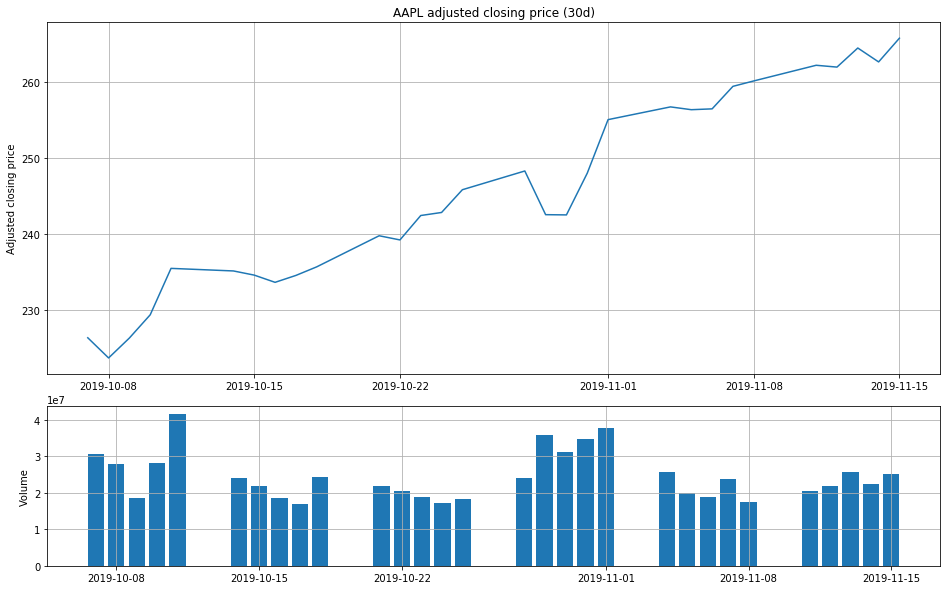

In [4]:
plt.figure(figsize=(16, 10))

price_ax = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=4)
price_ax.set_title(TICKER + ' adjusted closing price (' + PERIOD + ')')
price_ax.plot(data.Date, data['Adj Close'])
price_ax.set_ylabel('Adjusted closing price')
price_ax.grid(True)

volume_ax = plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=4)
volume_ax.bar(data.Date, data.Volume)
volume_ax.set_ylabel('Volume')
volume_ax.grid(True)

plt.show()

In [5]:
start_date = dt.datetime.today() - dt.timedelta(days=30)
end_date = dt.datetime.today()
news = newsapi.get_everything(q='Apple', sources=BUSINESS_SOURCES, from_param=str(start_date), to=str(end_date), sort_by='publishedAt', page_size=100)

In [6]:
def market_sentiment_score(text):
    # TextBlob score
    score_textblob = TextBlob(text)
    # 1 - Gets objective score
    if score_textblob.sentiment.polarity != 0:
        score_textblob = score_textblob.sentiment.polarity * (1 - score_textblob.sentiment.subjectivity)
    else:
        score_textblob = 0

    # Vader score
    score_vader = SentimentIntensityAnalyzer().polarity_scores(text)
    if score_vader['neu'] != 1:
        score_vader = score_vader['compound']
    else:
        score_vader = 0

    count = (1 if score_textblob != 0 else 0) + (1 if score_vader != 0 else 0)
    if count != 0:
        return round((score_textblob + score_vader) / count, 1)
    else:
        return None

In [7]:
documents = {}

for article in news['articles']:
    published_date = dt.datetime.strptime(article['publishedAt'],'%Y-%m-%dT%H:%M:%SZ')

    document = {}
    document['source'] = article['source']['name']
    document['title'] = article['title']
    document['description'] = article['description']
    document['time'] = published_date.strftime("%H:%M:%S")

    calendar_day = published_date.strftime("%Y-%m-%d")
    if calendar_day in documents:
        documents[calendar_day].insert(0, document)
    else:
        documents[calendar_day] = []
        documents[calendar_day].append(document)

In [8]:
def compute_weighted_score(scores):
    if not scores:
        return None
    elif len(scores) == 1:
        return scores[0]
    else:
        # Compute coefficients: the sooner the news, the more important.
        # News from yesterday affect today's stock price. The latest news is the most important.
        coeffs = []
        start = 1.0
        stop = 1.6
        delta = stop - start
        div = len(scores) - 1
        step = delta / div
        coeffs.append(start)
        for i in range(div):
            coeffs.append(coeffs[i] + step)

        weighted_score = 0
        for index, score in enumerate(scores):
            weighted_score += score * coeffs[index]
        weighted_score /= len(scores)

        return round(weighted_score, 1)

In [12]:
for date, doc in documents.items():
    print('> ' + (doc[0]['source'] or '-') + ', ' + date + '\n')
    scores_1 = []
    scores_2 = []
    for d in doc:
        print('at: ' + d['time'])
        print('title: "' + d['title'] + '"')
        print('description: "' + (d['description'] or 'None') + '"\n')

        score_2 = market_sentiment_score(d['description'] or '')

        # Don't rely on the title alone if there's no description.
        score_1 = market_sentiment_score(d['title'] or '') if score_2 is not None else None
        #print('score1: ' + str(score_1))
        if score_1 is not None:
            scores_1.append(score_1)

        #print('score2: ' + str(score_2) + '\n')
        if score_2 is not None:
            scores_2.append(score_2)

    total_score_1 = compute_weighted_score(scores_1)
    total_score_2 = compute_weighted_score(scores_2)
    if total_score_1 is not None and total_score_2 is not None:
        total_score = total_score_1 * 0.2 + total_score_2 * 0.8 # title is only worth 20%, description 80%
    else:
        total_score = total_score_1 or total_score_2

    if total_score is not None:
        total_score = round(((total_score / 2) + 0.5) * 5, 1)

    #print('total_score_1: ' + str(total_score_1))
    #print('total_score_2: ' + str(total_score_2))
    print('total_day_score: ', end='')
    if total_score is not None:
        print(str(total_score), end='')
    else:
        print('-', end='')
    print('/5 stars\n')

> Bloomberg, 2019-11-15

at: 16:08:38
title: "Apple Bans Vaping Apps From App Store on Growing Health Concerns"
description: "None"

at: 22:28:00
title: "Dow Industrials climbs past 28,000 for first time"
description: "NEW YORK - The U.S. stock market just reached another milestone, as the Dow Jones Industrial Average passed the 28,000 threshold for the first time, extending its gain for the year to 20%. Apple Inc. led the rally, surging 68%…"

total_day_score: 3.2/5 stars

> Bloomberg, 2019-11-14

at: 02:02:31
title: "Elizabeth Warren Slams Goldman Over Apple Card Bias Allegations"
description: "Elizabeth Warren Slams Goldman Over Apple Card Bias Allegations bloomberg.com"

at: 11:00:00
title: "Apple Is Considering Bundling Digital Subscriptions as Soon as 2020 - Bloomberg"
description: "Apple Is Considering Bundling Digital Subscriptions as Soon as 2020 Bloomberg Apple Reportedly Wants to Bundle Apple TV+, News+, & Apple Music Cord Cutters News, LLC Apple could bundle news, TV, and m

total_day_score: 2.6/5 stars

> Bloomberg, 2019-10-27

at: 01:18:31
title: "Microsoft to Expand Pentagon Ties With $10 Billion JEDI Contract"
description: "Microsoft Corp. said it’s seeking to expand its partnership with the Pentagon after winning the sought-after JEDI cloud computing contract valued at as much as $10 billion over a decade, dealing a blow to the market leader Amazon.com Inc."

total_day_score: 3.6/5 stars

> Bloomberg, 2019-10-25

at: 08:00:24
title: "What Big Tech Could Look Like Under President Elizabeth Warren"
description: "The Democratic contender sees lasting harm when one company dominates a market, even if consumers pay lower prices."

at: 16:54:53
title: "Apple (AAPL) In Discussions to Upgrade United (UAL) SFO Terminal"
description: "Apple (AAPL) In Discussions to Upgrade United (UAL) SFO Terminal bloomberg.com"

at: 17:47:17
title: "Ed Norton: Spike Lee Taught Me the Secret to Filming in New York City"
description: "The director, star, and writer of Motherles